<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

# Project: Linear models

## Programming project: real estate assesment evaluation

Home valuation is key in real estate industry, and also the basis for mortgages in credit sector. Here we have to predict the estimated value of a property.


Data (*Regression_Supervised_Train.csv*) consist of a list of features plus the resulting <i>parcelvalue</i>, described in *Case_data_dictionary.xlsx* file. Each row corresponds to a particular home valuation, and <i>transactiondate</i> is the date when the property was effectively sold. Properties are defined by <i>lotid</i>, but be aware that one property can be sold more than once (it's not the usual case). Also notice that some features are sometime empty, your model has to deal with it.

Note that you shouldn't use <i>totaltaxvalue</i>, <i>buildvalue</i> or <i>landvalue</i>, because they are closely correlated with the final value to predict. There is a further member of the training set predictors which is not available in the test set and therefore needs removing. 

+ Using this data build a predictive model for <i>parcelvalue</i> 
+ In your analysis for faster algorithms use the AIC criterion for choosing any hyperparameters 
+ Try a first quick implementation, then try to optimize hyperparameters
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the MSE estimate on the test data once released.
+ Bonus: Try an approach to fill NA without removing features or observations, and check improvements.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. Report missing data
2. As a simplified initial version, get rid of *missing data* by:
    + Remove columns '<i>totaltaxvalue</i>', '<i>buildvalue</i>' or '<i>landvalue</i>' from the training and testing set and also '<i>mypointer</i>' from the training set
    + Removing features that have more than 40% of missing data in the training set (remember anything you remove from the training set must be removed form the testing set!) (HINT: data.dropna(axis=1, thresh=round(my_percentage_valid*len(data.index)) - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
    + After that, removing observations that have missing data
3. Create *dummy variables* for relevant categorical features (EXTENDED PROJECT ONLY)
4. *Build* your model and test it on the same input data
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Prepare the code to *run* on a new input file and be able to report accuracy, following same preparation steps (missing data, dummies, etc)

You may want to iterate to refine some of these steps once you get performance results in step 5.


## Main criteria for grading
From more to less important (the weighting of these components will vary between the in-class and extended projects):
+ Code runs
+ Parcel value prediction made
+ Accuracy of predictions for test properties is calculated (kaggle)
+ Linear Models(s) and LASSO have been used
+ Accuracy itself
+ Data preparation
+ Hyperparameter optimization
+ Code is combined with neat and understandable commentary, with some titles and comments (demonstrate you have understood the methods and the outputs produced)
+ Improved methods from what we discussed in class (properly explained/justified)

In [1]:
# Loading the relevant modules
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from string import ascii_letters
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.preprocessing import scale as scl
from sklearn.model_selection import GridSearchCV
from IPython.display import display, Math, Latex
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score  
import statsmodels.api as sm
from sklearn.preprocessing import scale as scl

## Step 1: Read data, report missing data

### Loading data

In [2]:
# Read training set
df_train = pd.read_csv("Data/Regression_Supervised_Train.csv")

# Read testing set
df_test = pd.read_csv("Data/Regression_Supervised_Test.csv")

We remove the columns of the training set that are not in the testing set. Also, it is removed the columns `totaltaxvalue`, `buildvalue` or `landvalue` because they are closely correlated with the final value to predict `parcelvalue`.

In [3]:
# In the training set keep only columns which are in test dataset 
df_train = df_train[df_test.columns.to_list() + ["parcelvalue"]]

# Removing not needed variables
df_train = df_train.drop(['totaltaxvalue', 'buildvalue', 'landvalue'], axis=1)
df_test = df_test.drop(['totaltaxvalue', 'buildvalue', 'landvalue'], axis=1)

### Reporting missing values

It is possible to see there are several missing values in different variables. Properly dealing with this problem is key to obtain good predictions. We will use two strategies to solve this: 
1. Removing features that have more than 40% of missing data in the training set and then removing the rows with missing data. From the training set obtained after removing the missing values, we will construct a model to make predictions, which will work as a framework for other models that will try to fill some missing values instead of removing them.
2. Come up with reasonable estimates of what the values should be were they available (this is called *interpolation*) in some variables with more than 40% of missing values. Variables like `logerror`, `transactiondate`, `style`, `basement`, `classbuild`, `decktype`, `perimeterarea`, `totalarea`, `tubflag`, `poolarea`, `storytype`, `material`, `fireplace`, `taxdelinquencyflag` and `taxdelinquencyyear` have more than 90% of missing data (most of them more than 99%). For this reason, these variables will be removed and not a strategy will be created to try to fill them. 

Let's uncover the columns in the training set that contain null values:

In [4]:
# Create a pandas data frame with two columns a boolean column specifying whether the column has missing data and 
# another column specifying the percentage of missing values. 
mv_train = pd.DataFrame({'with_missing_values': df_train.isna().any(), 
              'percentage_missing_values':df_train.isnull().sum()*100/len(df_train)})

mv_train.sort_values(by=["percentage_missing_values"], ascending=False)

,with_missing_values,percentage_missing_values
perimeterarea,True,100.000000
classbuild,True,99.927287
storytype,True,99.773783
basement,True,99.773783
totalarea,True,99.749546
fireplace,True,99.240557
style,True,99.058776
material,True,98.994143
decktype,True,97.123813
taxdelinquencyyear,True,96.420925


We do the same for the testing set:

In [5]:
mv_test = pd.DataFrame({'with_missing_values': df_test.isna().any(), 
              'percentage_missing_values':df_test.isnull().sum()*100/len(df_test)})

mv_test.sort_values(by = "percentage_missing_values", ascending=False)

,with_missing_values,percentage_missing_values
totalarea,True,100.000000
poolarea,True,100.000000
basement,True,100.000000
classbuild,True,100.000000
finishedareaEntry,True,100.000000
decktype,True,100.000000
finishedarea1st,True,100.000000
storytype,True,100.000000
perimeterarea,True,100.000000
style,True,99.963583


It is possible to visualize missing data, for example using a heatmap where columns are in the x-axis and rows in the y-axis. Dark color represents non-missing values, while light color represents missing-values. 

<AxesSubplot:>

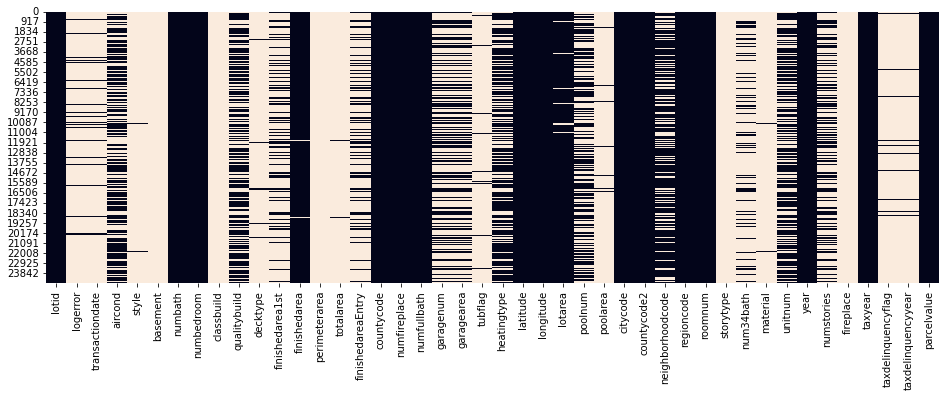

In [6]:
# Visualization of missing values in training set using heatmap
fig = plt.figure(figsize = (16, 5))        # Modify figure size
sns.heatmap(df_train.isnull(), cbar=False) # Create heatmap 

From the tables and the heatmap, we can note that several variables in our dataset have missing values. For example, `style`, `basement`, `classbuild`, `storytype`, `perimeterarea`, `totalare`, `tubflag`, `taxdeliquencyflag`, `taxdeliquencyyear`, among others, are variables with practically 100% of missing values. The same happens for the test set:

<AxesSubplot:>

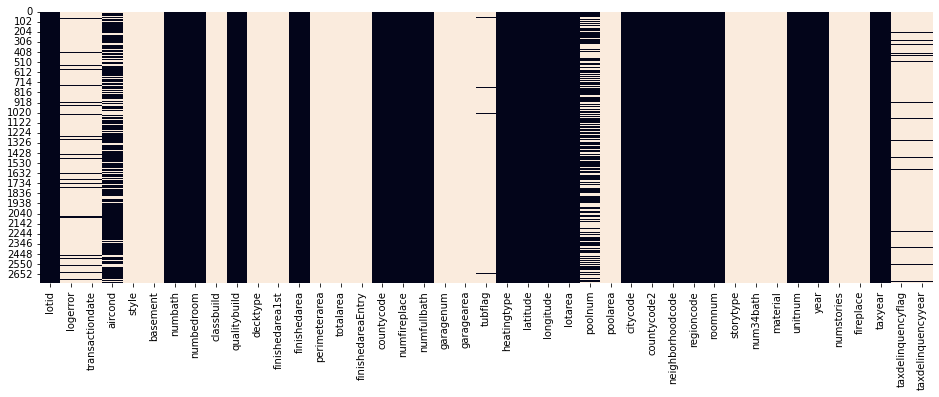

In [7]:
fig = plt.figure(figsize = (16, 5))        # Modify figure size
sns.heatmap(df_test.isnull(), cbar=False) # Create heatmap 

### Understanding data

An easy way to see correlations among the variables is to plot a correlation matrix using a heatmap. For example, note that the variables `numbath`, `finishedarea1st`, `finishedarea`, `numfullbath`, `garagenum` and `garagearea` are highly correlated with `parcelvalue`. Likewise, note that `finishedareaEntry` and `finishedareafirst` are highly correlated, the same happens for `numbath` and `numfullbath`, this could be indicating that multicollinearity is present in our data.

<AxesSubplot:>

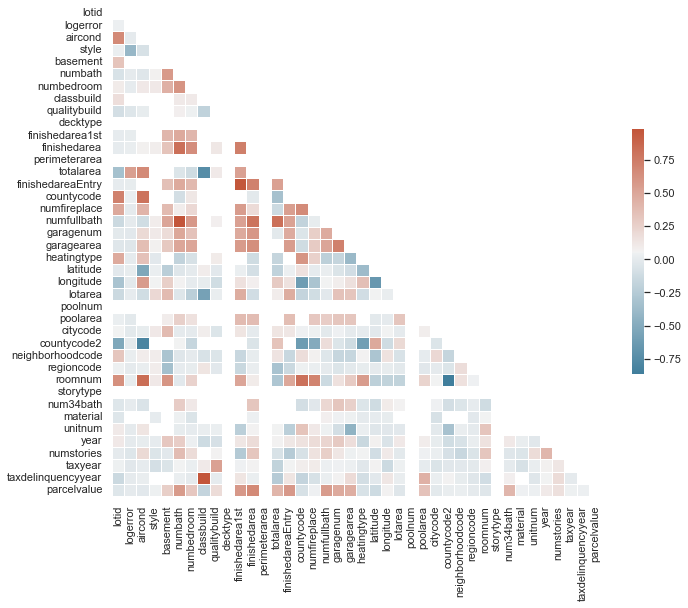

In [8]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

In addition, the variables `countycode` and `countycode2` are the same but with different values, i.e., when `countycode` is, for example, 6037, `countycode2` is 3101 (see the following table), then `countycode` will be removed. 

In [9]:
df_train[["countycode", "countycode2"]].head(10)

,countycode,countycode2
0,6111,2061
1,6037,3101
2,6037,3101
3,6037,3101
4,6111,2061
5,6059,1286
6,6037,3101
7,6059,1286
8,6037,3101
9,6037,3101


The following allows us to double-check that `countycode` and `countycode2` are giving us the same information.

In [10]:
df_train.countycode.value_counts()

6037    14754
6111     6144
6059     3857
Name: countycode, dtype: int64

In [11]:
df_train.countycode2.value_counts()

3101    14754
2061     6144
1286     3857
Name: countycode2, dtype: int64

Likewise, `numbath` and `numfullbath` are highly correlated, probably one of these variables must be removed from the model.

In [12]:
df_train[["numbath", "numfullbath"]].corr()

,numbath,numfullbath
numbath,1.000000,0.980519
numfullbath,0.980519,1.000000


### Analyzing `parcelvalue`

An important aspect in our predictive analysis is to understand, first, the the variable to be predicted (`parcelvalue`) and second, the relation among this variable and the other variables in the dataset. 

This is the distribution of `parcelvalue` as characterized by its descriptive statistics and a histogram:

In [13]:
df_train["parcelvalue"].describe()

count    2.475500e+04
mean     5.430185e+05
std      7.259855e+05
min      1.562300e+04
25%      2.396560e+05
50%      3.842500e+05
75%      6.090000e+05
max      2.563981e+07
Name: parcelvalue, dtype: float64

<AxesSubplot:xlabel='parcelvalue', ylabel='Count'>

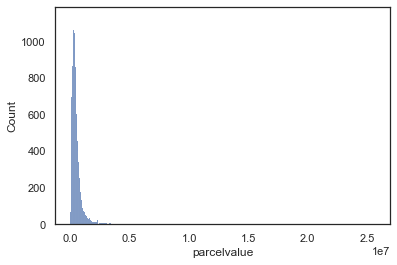

In [14]:
sns.histplot(x = "parcelvalue", data = df_train)

From the histogram we can see that the distribution is quite skewed to the right. This is corroborated by the fact that the difference between the 25th percentile and the 50th percentile is notably smaller than the difference between the 50th percentile and the 75th percentile. Thus, the distribution of properties prices is almost certainly not normal. The following plot gives us an insight around how `parcelvalue` is related to other variables in the training dataset:

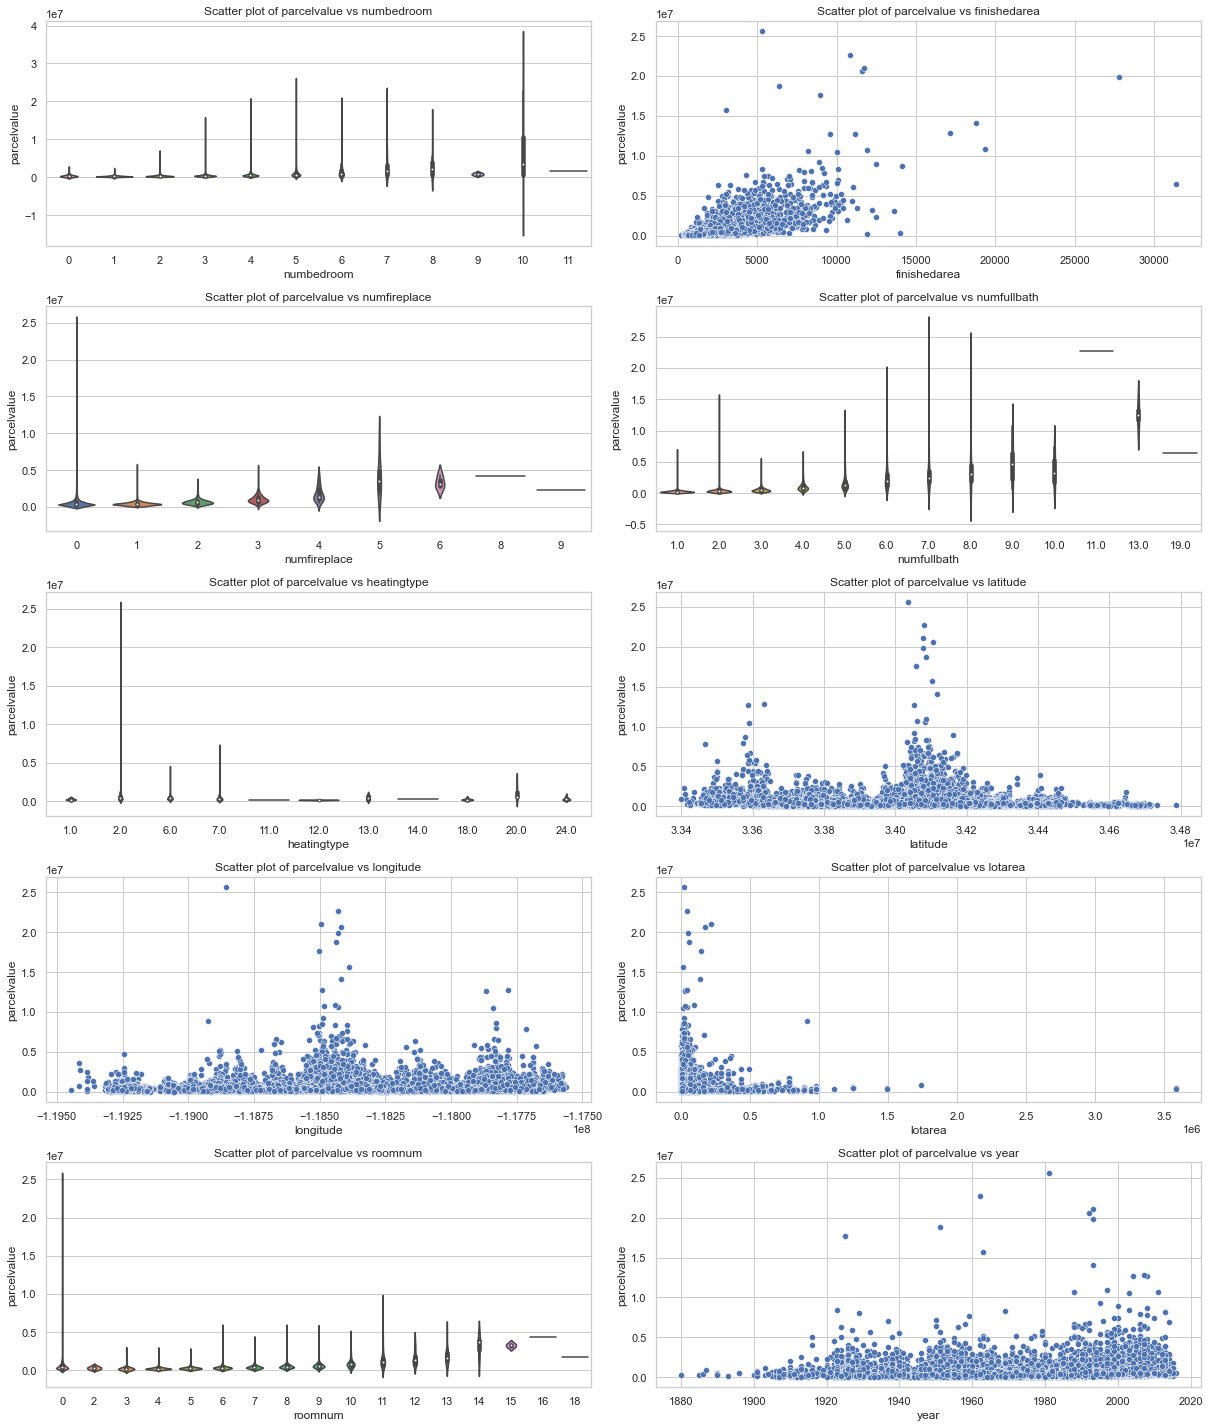

In [15]:
sns.set_theme(style="whitegrid")

# Iterate over variables in a list and create scatterplots for numerical variables and violinplots for categorical 
plt.figure(figsize=(17,20))
for i, var in enumerate(['numbedroom', 'finishedarea', 'numfireplace', 'numfullbath', 'heatingtype', 'latitude',
                         'longitude', 'lotarea', 'roomnum', 'year']):
    plt.subplot(5, 2, i+1)
    if var in ["finishedarea", "latitude", "longitude", "lotarea", "year"]:
        
        sns.scatterplot(y = "parcelvalue", x = var,data = df_train)
    else:
        sns.violinplot(y = "parcelvalue", x = var,data = df_train)
    plt.title("Scatter plot of parcelvalue vs" +  " " + var)
    legend_labels, _= ax.get_legend_handles_labels()
    
plt.tight_layout()

We have seen that the distribution of properties prices is not normal, and that this may be contributing to the "fanning out" effect we observed, for example, in the scatter plot `finishedarea` vs `parcelvalue`. We want to find a way to remove the "fanning out" effect, as it implies that a linear fit becomes less and less suitable for larger values of `finishedarea`. A common method of addressing this issue is to transform the dependent variable and the independent variable `finishedarea`. Such a variable transformation involves applying a function to one or more of these variables to achieve conditions that are suitable for the application of a linear model (See the following plot, note that once it is used a log transformation in both variables the relationship becomes practically linear). Additionally, note that variables like `longitude` and `latitude` seem to not have a linear relationship with `parcelvalue`, for this reason, we will add polynomials to these variables. Based on the curvature in the left center of the scatter plot between `parcelvalue` and `latitude`, it seems that adding a quadratic term could help us to improve the fit. 

<AxesSubplot:xlabel='finishedarea', ylabel='parcelvalue'>

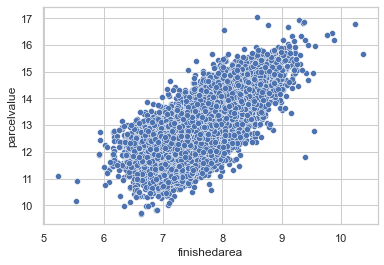

In [16]:
sns.scatterplot(y=np.log(df_train["parcelvalue"]), x=np.log(df_train["finishedarea"]), data=df_train)

## Step 2: Remove features with missing data, and then observations with missing data

As a first approximation we will remove features that have more than 40% of missing data in the training set, the same features will be removed from the testing set. These datasets will be named as `df_train_nh` and `df_test_nh` (`_nh` stands for no-handled missing values).  On the other hand, there will be two datasets named as `df_train_h` and `df_test_h` (`_h` stands for handled missing values) which will have filled some of the columns that have more than 40% of missing values. 

### First approach: Remove columns with more than 40% of missing values

In [17]:
# Convert to a list the names of variables which do NOT have more than 40% of missing values in the training set
no_40_missing_values = mv_train[mv_train["percentage_missing_values"] < 40].index.to_list()

# Keep in both datasets the variables with no more than 40% of missing values in the training set
df_train_nh = df_train[no_40_missing_values]     # Keep variables in the training set
df_test_nh = df_test[no_40_missing_values[:-1]]  # Keep variables in the testing set except for parcelvalue

# Remove additional columns: countycode and numbath. (countycode2 and numbath provide practically the same information)
cols_to_drop = ["countycode", "numbath"]

df_train_nh = df_train_nh.drop(cols_to_drop, axis = 1)
df_test_nh = df_test_nh.drop(cols_to_drop, axis = 1)

# Now, remove the observations with missing values from both datasets
df_train_nh = df_train_nh.dropna()
df_test_nh = df_test_nh.dropna()

In [18]:
df_train_nh

,lotid,numbedroom,finishedarea,numfireplace,numfullbath,heatingtype,latitude,longitude,lotarea,citycode,countycode2,neighborhoodcode,regioncode,roomnum,year,taxyear,parcelvalue
3,11047729,3,1757.0,0,2.0,2.0,34252019,-118467570,8612.0,12447.0,3101,116646.0,96371.0,0,1952.0,2015,270543.0
6,11016338,3,1663.0,0,3.0,2.0,34284508,-118493574,12102.0,12447.0,3101,31817.0,96370.0,0,1961.0,2016,363524.0
8,11671803,3,1777.0,0,3.0,2.0,34076404,-118560997,363116.0,12447.0,3101,19810.0,96120.0,0,1978.0,2015,329781.0
9,11150386,4,2198.0,0,3.0,2.0,34398126,-118448101,5815.0,54311.0,3101,37739.0,96401.0,0,2000.0,2015,360647.0
13,10965295,3,1231.0,0,3.0,2.0,34315800,-118443000,140609.0,12447.0,3101,34213.0,96368.0,0,1989.0,2015,186549.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24747,11692375,4,4611.0,0,5.0,2.0,34104857,-118484435,341421.0,12447.0,3101,113910.0,96030.0,0,1990.0,2015,2251206.0
24748,12026030,3,3340.0,0,3.0,2.0,34113968,-118362226,8847.0,12447.0,3101,274049.0,96027.0,0,1975.0,2016,920386.0
24750,11633053,2,1382.0,0,3.0,2.0,34084400,-118379000,17166.0,48424.0,3101,762180.0,96050.0,0,1982.0,2016,786817.0
24751,10751511,2,1127.0,0,2.0,2.0,34134687,-118725713,289439.0,9840.0,3101,764088.0,96336.0,0,1973.0,2015,282464.0


In [19]:
df_test_nh

,lotid,numbedroom,finishedarea,numfireplace,numfullbath,heatingtype,latitude,longitude,lotarea,citycode,countycode2,neighborhoodcode,regioncode,roomnum,year,taxyear
0,11614222,3,1618.0,0,3.0,2.0,34048500,-118438000,19423.0,12447.0,3101,118887.0,96006,0,1975.0,2015
1,11555888,3,1817.0,0,2.0,2.0,34023816,-118429617,7625.0,12447.0,3101,116415.0,96047,0,1948.0,2015
2,13052987,3,1549.0,0,2.0,2.0,34125379,-117707983,11080.0,30908.0,3101,764142.0,96469,0,1978.0,2016
3,12448473,3,1275.0,0,3.0,2.0,33878735,-118171388,58881.0,46298.0,3101,276476.0,96239,0,1991.0,2015
4,12559155,1,600.0,0,1.0,2.0,33766300,-118188000,47343.0,46298.0,3101,273486.0,96236,0,2004.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,10991930,1,672.0,0,1.0,7.0,34276978,-118342702,447679.0,12447.0,3101,268249.0,96368,0,1946.0,2015
2742,11103888,4,1140.0,0,1.0,2.0,34424797,-118472198,6224.0,54311.0,3101,37739.0,96374,0,1962.0,2015
2743,11614730,2,1368.0,0,3.0,2.0,34046900,-118440000,6614.0,12447.0,3101,118887.0,96006,0,1981.0,2015
2744,10910905,2,1506.0,0,3.0,2.0,34144700,-118388000,280590.0,12447.0,3101,47880.0,96449,0,1973.0,2015


### Second approach: Filling columns

First, remove columns with more than 90% of missing values and variables `countycode2` and `numfullbath`

In [20]:
# Remove columns with more than 90% of missing values
df_train_h = df_train[mv_train[mv_train["percentage_missing_values"] < 90].index.to_list()]

# Remove countycode because it gives the same information as countycode2 and numbath because is highly correlated with numbath2
df_train_h = df_train_h.drop(["countycode", "numfullbath"], axis = 1)

Second, fill the categorical variables `aircond`, `qualitybuild` and `heatingtype` with the values that are repeated more frequently in the neigborhood where the properties are located (mode value). In case the variables are bimodal, we will take arbitrarily the first mode. For doing this, we will group by our dataset by `neighborhoodcode` and get the mode for `aircond`, `qualitybuild` and `heatingtype`.

In [21]:
modes_df = df_train_h.groupby("neighborhoodcode")[["aircond", "qualitybuild", "heatingtype"]].agg(pd.Series.mode)
modes_df

,aircond,qualitybuild,heatingtype
neighborhoodcode,,,
6952.0,1.0,4.0,2.0
7877.0,1.0,7.0,2.0
11950.0,[],"[4.0, 7.0]",2.0
13017.0,1.0,4.0,2.0
13176.0,1.0,7.0,2.0
...,...,...,...
764149.0,1.0,8.0,2.0
764152.0,1.0,7.0,2.0
764153.0,1.0,4.0,2.0


Notice that there are several neighborhood codes with no modes and other with more than one mode, therefore it is necessary to select one of them and put `NaN` insted of `[]`.

In [22]:
%run "Functions/get_value.py"        
modes_df = modes_df.applymap(get_value)
modes_df

,aircond,qualitybuild,heatingtype
neighborhoodcode,,,
6952.0,1.0,4.0,2.0
7877.0,1.0,7.0,2.0
11950.0,NaN,4.0,2.0
13017.0,1.0,4.0,2.0
13176.0,1.0,7.0,2.0
...,...,...,...
764149.0,1.0,8.0,2.0
764152.0,1.0,7.0,2.0
764153.0,1.0,4.0,2.0


<Figure size 432x288 with 0 Axes>

In [23]:
# Reset index to have neighborhood code as a variable
modes_df = modes_df.reset_index()

# Define column names before joining to the training set
modes_df.columns = ["neighborhoodcode", "aircond_mode", "qualitybuild_mode", "heatingtype_mode"]

# Left join with training set
df_train_h = df_train_h.merge(modes_df, on='neighborhoodcode', how='left')

In [24]:
# Fill variables using the mode
df_train_h["aircond"] = df_train_h["aircond"].fillna(df_train_h["aircond_mode"])
df_train_h["qualitybuild"] = df_train_h["qualitybuild"].fillna(df_train_h["qualitybuild_mode"])
df_train_h["heatingtype"] = df_train_h["heatingtype"].fillna(df_train_h["heatingtype_mode"])

In [25]:
# Show percentage of missing values once we have fill some variables with the mode
pd.DataFrame({'with_missing_values': df_train_h.isna().any(), 
              'percentage_missing_values':df_train_h.isnull().sum()*100/len(df_train_h)}).sort_values(by = "percentage_missing_values", ascending = False)

,with_missing_values,percentage_missing_values
num34bath,True,79.725308
finishedarea1st,True,75.184811
finishedareaEntry,True,75.184811
numstories,True,61.082610
garagenum,True,59.628358
garagearea,True,59.628358
qualitybuild_mode,True,49.287013
poolnum,True,48.612402
aircond_mode,True,44.217330
heatingtype_mode,True,44.132498


There is an improve in the `aircond` variable, where now we only have 29.8%, compared to the 41.54% that this variable had before. Likewise, `heatingtype` had 36.21% of missing values and with this strategy now has 31.97%.

In [26]:
# Dropping irrelevant variables
df_train_h = df_train_h.drop(["aircond_mode", "qualitybuild_mode", "heatingtype_mode"], axis = 1)

Now, let's fill missing values in numerical variables using the median of the neigborhood where the properties are located. The reason behind using the median is that these variables are right-skewed. 

In [27]:
# Numerical columns to obtain the median
cols_to_me = ["num34bath",  "finishedarea1st", "finishedareaEntry", "numstories", "garagenum", "garagearea", "numbedroom", 
              "unitnum", "lotarea", "finishedarea"]

# Group numerical columns by neigborhoodcode and get the median
me_df = df_train_h.groupby("neighborhoodcode")[cols_to_me].median()

me_df

,num34bath,finishedarea1st,finishedareaEntry,numstories,garagenum,garagearea,numbedroom,unitnum,lotarea,finishedarea
neighborhoodcode,,,,,,,,,,
6952.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,7874.0,1608.0
7877.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,6672.0,1723.0
11950.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,5890.5,1619.0
13017.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,10921.0,1598.0
13176.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,41851.0,1365.5
...,...,...,...,...,...,...,...,...,...,...
764149.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,10328.0,1926.0
764152.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,4961.0,1434.0
764153.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,7594.0,1349.0


In [28]:
# Reset index to have neighborhoodcode as a variable
me_df = me_df.reset_index()

# Names of columns we are filling with the median
names_me_columns = []
for var in cols_to_me:
    name = var+"_me"
    names_me_columns.append(name)

# Set column names
me_df.columns = ["neighborhoodcode"] + names_me_columns

# Left join with training set
df_train_h = df_train_h.merge(me_df, on='neighborhoodcode', how='left')

df_train_h

,lotid,aircond,numbath,numbedroom,qualitybuild,finishedarea1st,finishedarea,finishedareaEntry,numfireplace,garagenum,...,num34bath_me,finishedarea1st_me,finishedareaEntry_me,numstories_me,garagenum_me,garagearea_me,numbedroom_me,unitnum_me,lotarea_me,finishedarea_me
0,17214744,NaN,2.0,3,NaN,1255.0,1255.0,1255.0,1,2.0,...,1.0,1366.0,1366.0,2.0,2.0,483.0,4.0,NaN,8079.0,2000.5
1,12018724,1.0,2.0,1,4.0,NaN,1033.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11306699,1.0,3.0,4,4.0,NaN,2982.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11047729,1.0,2.0,3,7.0,NaN,1757.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,7995.0,1452.0
4,17174848,NaN,3.0,2,NaN,1047.0,1951.0,1047.0,0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24750,11633053,1.0,3.0,2,7.0,NaN,1382.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,17166.0,1256.0
24751,10751511,1.0,2.0,2,7.0,NaN,1127.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,13923.0,2068.5
24752,10719915,1.0,2.0,4,6.0,NaN,2179.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,29336.0,1229.0
24753,11639212,1.0,5.0,5,10.0,NaN,3807.0,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Filling some missing values using the median
for var in cols_to_me:
    df_train_h[var] = df_train_h[var].fillna(df_train_h[var+"_me"])

# Drop the variables we used to fill the missing values with the median      
df_train_h = df_train_h.drop(names_me_columns, axis=1)

Looking at `poolnum` it is possible to see that it only contains missing values and 1s, this could lead us to think that the values that are not missing values probably are 0s (meaning that the property does not have pool). We will fill the missing values in this variable using 0s.

In [30]:
# Probably the missing values are zero
df_train_h["poolnum"].value_counts()

# Fill with 0s observations with missing values
df_train_h["poolnum"] = df_train_h["poolnum"].fillna(0)

Now, we can see that the variables that we have treated have less than 40% of missing values. 

In [31]:
mv_train_h = pd.DataFrame({'with_missing_values': df_train_h.isna().any(), 
              'percentage_missing_values':df_train_h.isnull().sum()*100/len(df_train_h)}).sort_values(by = "percentage_missing_values", ascending = False)

mv_train_h

,with_missing_values,percentage_missing_values
finishedarea1st,True,74.106241
finishedareaEntry,True,74.106241
num34bath,True,73.762876
garagenum,True,58.545748
garagearea,True,58.545748
numstories,True,56.000808
qualitybuild,True,40.395880
unitnum,True,40.222177
neighborhoodcode,True,39.297112
heatingtype,True,31.977378


Lastly, we proceed to keep the variables with less than the 41% of missing values. 

In [32]:
df_train_h = df_train_h[mv_train_h[mv_train_h["percentage_missing_values"] < 41].index.to_list()]
df_train_h = df_train_h.dropna()
df_train_h

,qualitybuild,unitnum,neighborhoodcode,heatingtype,aircond,lotarea,citycode,finishedarea,year,regioncode,...,roomnum,lotid,longitude,countycode2,poolnum,latitude,numfireplace,numbedroom,numbath,parcelvalue
3,7.0,1.0,116646.0,2.0,1.0,8612.0,12447.0,1757.0,1952.0,96371.0,...,0,11047729,-118467570,3101,0.0,34252019,0,3,2.0,270543.0
6,8.0,1.0,31817.0,2.0,1.0,12102.0,12447.0,1663.0,1961.0,96370.0,...,0,11016338,-118493574,3101,1.0,34284508,0,3,3.0,363524.0
8,4.0,1.0,19810.0,2.0,1.0,363116.0,12447.0,1777.0,1978.0,96120.0,...,0,11671803,-118560997,3101,0.0,34076404,0,3,3.0,329781.0
9,4.0,1.0,37739.0,2.0,1.0,5815.0,54311.0,2198.0,2000.0,96401.0,...,0,11150386,-118448101,3101,0.0,34398126,0,4,3.0,360647.0
13,4.0,1.0,34213.0,2.0,1.0,140609.0,12447.0,1231.0,1989.0,96368.0,...,0,10965295,-118443000,3101,1.0,34315800,0,3,3.0,186549.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24747,10.0,1.0,113910.0,2.0,1.0,341421.0,12447.0,4611.0,1990.0,96030.0,...,0,11692375,-118484435,3101,0.0,34104857,0,4,5.0,2251206.0
24748,9.0,1.0,274049.0,2.0,1.0,8847.0,12447.0,3340.0,1975.0,96027.0,...,0,12026030,-118362226,3101,1.0,34113968,0,3,3.0,920386.0
24750,7.0,1.0,762180.0,2.0,1.0,17166.0,48424.0,1382.0,1982.0,96050.0,...,0,11633053,-118379000,3101,1.0,34084400,0,2,3.0,786817.0
24751,7.0,1.0,764088.0,2.0,1.0,289439.0,9840.0,1127.0,1973.0,96336.0,...,0,10751511,-118725713,3101,1.0,34134687,0,2,2.0,282464.0


We do the same process but for the testing set. 

In [33]:
# List with columns that have been removed from the testing set
a = list(set(df_train.columns)-set(df_train_h.columns))

# List with columns that we need to leave 
columns_to_keep = list(set(df_test.columns)-set(a))

# Keep only columns in columns_to_keep
df_test_h = df_test[columns_to_keep]

df_test_h 

,unitnum,lotid,longitude,lotarea,roomnum,taxyear,aircond,qualitybuild,countycode2,finishedarea,neighborhoodcode,citycode,numbath,year,numfireplace,poolnum,numbedroom,heatingtype,latitude,regioncode
0,1.0,11614222,-118438000,19423.0,0,2015,1.0,4.0,3101,1618.0,118887.0,12447.0,3.0,1975.0,0,NaN,3,2.0,34048500,96006
1,1.0,11555888,-118429617,7625.0,0,2015,NaN,4.0,3101,1817.0,116415.0,12447.0,2.0,1948.0,0,1.0,3,2.0,34023816,96047
2,1.0,13052987,-117707983,11080.0,0,2016,1.0,8.0,3101,1549.0,764142.0,30908.0,2.0,1978.0,0,1.0,3,2.0,34125379,96469
3,1.0,12448473,-118171388,58881.0,0,2015,1.0,4.0,3101,1275.0,276476.0,46298.0,3.0,1991.0,0,NaN,3,2.0,33878735,96239
4,1.0,12559155,-118188000,47343.0,0,2015,1.0,NaN,3101,600.0,273486.0,46298.0,1.0,2004.0,0,1.0,1,2.0,33766300,96236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,1.0,10991930,-118342702,447679.0,0,2015,NaN,7.0,3101,672.0,268249.0,12447.0,1.0,1946.0,0,NaN,1,7.0,34276978,96368
2742,1.0,11103888,-118472198,6224.0,0,2015,NaN,7.0,3101,1140.0,37739.0,54311.0,1.0,1962.0,0,NaN,4,2.0,34424797,96374
2743,1.0,11614730,-118440000,6614.0,0,2015,1.0,4.0,3101,1368.0,118887.0,12447.0,3.0,1981.0,0,NaN,2,2.0,34046900,96006
2744,1.0,10910905,-118388000,280590.0,0,2015,1.0,4.0,3101,1506.0,47880.0,12447.0,3.0,1973.0,0,1.0,2,2.0,34144700,96449


In [34]:
# Fill poolnum with 0s
df_test_h["poolnum"] = df_test_h["poolnum"].fillna(0)

# Obtain the modes by neighborhoodcode for categorical variables
modes_df_test = df_test_h.groupby("neighborhoodcode").agg(pd.Series.mode)[["aircond", "qualitybuild", "heatingtype"]].head(50)
modes_df_test = modes_df_test.applymap(get_value)
modes_df_test = modes_df_test.reset_index()
modes_df_test.columns = ["neighborhoodcode", "aircond_mode", "qualitybuild_mode", "heatingtype_mode"]

# Join with testing set
df_test_h = df_test_h.merge(modes_df_test, on='neighborhoodcode', how='left')

#Replace missing values with the modes by neighborhoodcode
df_test_h["aircond"] = df_test_h["aircond"].fillna(df_test_h["aircond_mode"])
df_test_h["qualitybuild"] = df_test_h["qualitybuild"].fillna(df_test_h["qualitybuild_mode"])
df_test_h["heatingtype"] = df_test_h["heatingtype"].fillna(df_test_h["heatingtype_mode"])

# Drop variables we created to fill the missing values with the mode
df_test_h = df_test_h.drop(["aircond_mode", "qualitybuild_mode", "heatingtype_mode"], axis = 1)

<ipython-input-34-42701483af8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_h["poolnum"] = df_test_h["poolnum"].fillna(0)


Now let's fill numerical variables with the median, in this case it is only necessary to fill `unitnum`, since is the only numerical variable with missing values. 

In [35]:
df_test_h.isna().sum()

unitnum              19
lotid                 0
longitude             0
lotarea               0
roomnum               0
taxyear               0
aircond             258
qualitybuild         35
countycode2           0
finishedarea          0
neighborhoodcode      0
citycode              0
numbath               0
year                  0
numfireplace          0
poolnum               0
numbedroom            0
heatingtype           0
latitude              0
regioncode            0
dtype: int64

In [36]:
# Columns to obtain the median
cols_to_me = ["unitnum"]

me_df = df_test_h.groupby("neighborhoodcode")[cols_to_me].median()

In [37]:
# Reset index to have the neighborhoodcode
me_df = me_df.reset_index()

# Names of columns that we add the median
names_me_columns = []
for var in cols_to_me:
    name = var+"_me"
    names_me_columns.append(name)

# Set column names
me_df.columns = ["neighborhoodcode"] + names_me_columns

# Left join with testing set
df_test_h = df_test_h.merge(me_df, on='neighborhoodcode', how='left')

# Fill missing values with the median
df_test_h["unitnum"] = df_test_h["unitnum"].fillna(df_test_h["unitnum_me"])

Even though several observations were filled in, there are still observations with missing values. This is because there is no variable information for certain neighborhoodcodes. As a last strategy, it is decided to fill these observations with the average values of the variables.

In [38]:
# Drop irrelevant variables that were created to fill missing values with the median 
df_test_h = df_test_h.drop(names_me_columns, axis = 1) 

# If there are still missing values, fill them with the median 
df_test_h = df_test_h.fillna(df_test_h.median())

# Zero missing values
df_test_h.isna().sum()

unitnum             0
lotid               0
longitude           0
lotarea             0
roomnum             0
taxyear             0
aircond             0
qualitybuild        0
countycode2         0
finishedarea        0
neighborhoodcode    0
citycode            0
numbath             0
year                0
numfireplace        0
poolnum             0
numbedroom          0
heatingtype         0
latitude            0
regioncode          0
dtype: int64

## Step 3: Create dummies for relevant features


Many machine learning algorithms cannot work with categorical data directly. Therefore, in order to include categorical variables in the model, we must convert them into binary vectors. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1. This method is known as *one-hot encoding*. 

The following code applies one-hot encoding to the categorical variables in our datasets. The `lotid` variable is not converted into binary vectors as this variable is only used for identifying observations and is not useful for predicting purposes.

In [39]:
# For datasets without handled missing values
df_train_nh = pd.get_dummies(df_train_nh, prefix=['countycode2', 'citycode', 'regioncode', 'neighborhoodcode', "taxyear", 
                                                  "heatingtype"], 
                columns=['countycode2','citycode', 'regioncode', 'neighborhoodcode', "taxyear", "heatingtype"], drop_first=True)

df_test_nh = pd.get_dummies(df_test_nh, prefix=['countycode2', 'citycode', 'regioncode', 'neighborhoodcode', "taxyear", 
                                               "heatingtype"], 
                columns=[ 'countycode2','citycode', 'regioncode', 'neighborhoodcode', "taxyear", "heatingtype"], drop_first=True)

In [40]:
# For datasets with handled missing values
df_train_h = pd.get_dummies(df_train_h, prefix=['countycode2', 'citycode', 'regioncode', 'neighborhoodcode', 
                                                "taxyear", "heatingtype"], 
               columns=['countycode2','citycode', 'regioncode', 'neighborhoodcode', "taxyear", "heatingtype"], drop_first=True)

df_test_h = pd.get_dummies(df_test_h, prefix=['countycode2', 'citycode', 'regioncode', 'neighborhoodcode', 
                                              "taxyear", "heatingytpe"], 
               columns=['countycode2', 'citycode','regioncode', 'neighborhoodcode', "taxyear", "heatingtype"], drop_first=True)

## Step 4: Build your model and get predictions from train data and Step 5: Assess expected accuracy

In this part we include step 4 and 5. In total, 7 models are created, 3 with Linear Regressions and 3 with Lasso. For the Lasso Regression it is used the function `LassoLarsIC` from `sklearn`. This function makes a Lasso model fit using AIC (Akaike Information Criterion) for model selection. Then, `LassoLarsIC` selects the value of the regularization parameter ($\lambda$ - denoted as *alpha* by sklearn) by making a trade-off between the goodness of fit and the complexity of the model. 

1. **First model**: Linear regression with `parcelvalue` in levels and regressors from the dataset without handled missing values (`df_train_nh`). 
2. **Second model**: Linear regression with `parcelvalue` in levels and regressors from the dataset with handled missing values (`df_train_nh`). 
3. **Third model**: Linear regression with $Log(parcelvalue)$ and regressors from the dataset without handled missing values except for variables `numfireplace`, `lotarea` and `roomnum`, which are removed based on the results obtained from model 1, where it is possible to see that these variables are statistically insignificant (This will be explained in Model 1 section). 
4. **Fourth model**: Linear regression with $Log(parcelvalue)$ and regressors from the dataset with handled missing values except for variables `numfireplace`, `lotarea` and `roomnum`, which are removed based on the results obtained from model 1, where it is possible to see that these variables are statistically insignificant (This will be explained in Model 1 section). 
5. **Fifth model**: Linear regression with $Log(parcelvalue)$ and regressors from the dataset without handled missing values (except for variables `numfireplace`, `lotarea` and `roomnum`) plus $Log(finishedarea)$, $Latitude^2$ and $Longitude^2$ 
6. **Sixth model**: Linear regression with $Log(parcelvalue)$ and regressors from the dataset with handled missing values (except for variables `numfireplace`, `lotarea` and `roomnum`) plus $Log(finishedarea)$, $Latitude^2$ and $Longitude^2$ 
6. **Seventh model**: Lasso regression with $Log(parcelvalue)$ and scaled regressors from the dataset without handled missing values except for variables `numfireplace`, `lotarea` and `roomnum`..
7. **Eigth model**: Lasso regression with $Log(parcelvalue)$ and scaled regressors from the dataset with handled missing values, except for variables `numfireplace` and `lotarea` 

The model with the best performance in the kaggle competition was *Fifth Model*. 

### First model 

In [41]:
# Defining X matrix with all regressors and parcelvalue as the dependent variable, dropping parcelvalue and lotid
X_train = df_train_nh.drop(["lotid", "parcelvalue"], axis = 1)
y_train = df_train_nh.parcelvalue
X = X_train.copy()
y = y_train.copy()

# Instantiating LinearRegression
model1 = LinearRegression()

# Fitting model
model1.fit(X, y)

LinearRegression()

Check the results from Model: 

In [42]:
model_linear = sm.OLS(y_train, sm.add_constant(X_train))
original_linear = model_linear.fit()
print(original_linear.summary())

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:            parcelvalue   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     29.65
Date:                Sun, 07 Nov 2021   Prob (F-statistic):               0.00
Time:                        23:42:35   Log-Likelihood:            -1.8365e+05
No. Observations:               12560   AIC:                         3.683e+05
Df Residuals:                   12049   BIC:                         3.721e+05
Df Model:                         510                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

From the last table we can see that `numfireplace`, `roomnum` and `lotarea` are not statistically significant, so we are going to remove them for the other models. On the other hand, let's check how our model is doing for predicting the `parcelvalue` in the training dataset that we already know (insample predictions). 

Text(0.5, 1.0, 'R-squared equals 0.557')

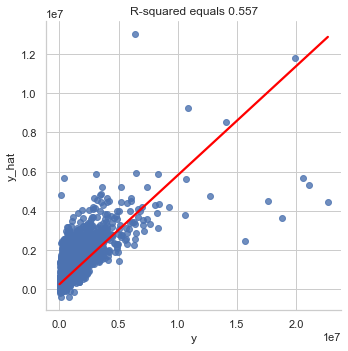

In [43]:
y_hat = model1.predict(X) # Insample predictions
sns.set_theme(style="whitegrid")
sns.lmplot(x="y", y="y_hat", data = pd.DataFrame({"y": y, "y_hat": y_hat}), ci=None,line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title("R-squared equals %.3f" %r2_score(y, y_hat))

We obtain an $R^2 = 0.557$ in the training dataset, which means that $55.7\%$ variance of the `parcelvalue` variable is explained by the independent variables included in the regression model. A large R−squared is equivalent to small sum of squared errors.

For predicting `parcelvalue` in the testing set, we need to have the same variables in the training set and the testing set. The following code allows us to remove columns (dummy variables) from the testing set which are not in the training data and, the ones that are in the training data but not in the testing data are created and filled with 0s. 

In [44]:
# X matrix for testing data
X_test = df_test_nh.drop("lotid", axis = 1)

# Get missing columns in the testing test
missing_cols = set(X.columns) - set(X_test.columns)

# Adding missing columns in the testing set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set. 
X_test_original = X_test[X.columns]

# Create a copy of X_test_original named X_test
X_test = X_test_original.copy()

<ipython-input-44-c88d33545ff1>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[c] = 0


Now that we have trained our model, let's get the predictions for the testing set using `X_test`, this will be the out of sample predictions. 

In [45]:
# Predicting the values in the testing set using X_test 
y_hat = model1.predict(X_test) 

# Get the mean of the predicted prices
y_hat.mean()

466178.67950659135

### Second model 

In [46]:
# Defining X matrix with all regressors and parcelvalue as y as the dependent variable
X_train_h = df_train_h.drop(["lotid", "parcelvalue"], axis = 1)
y_train_h = df_train_h.parcelvalue
X_h = X_train_h.copy()
y_h = y_train_h.copy()
X_h = X_h.drop(["numfireplace", "lotarea", "roomnum"], axis = 1)
model2 = LinearRegression()
model2.fit(X_h, y_h)

LinearRegression()

Model Evaluation:

Text(0.5, 1.0, 'R-squared equals 0.558')

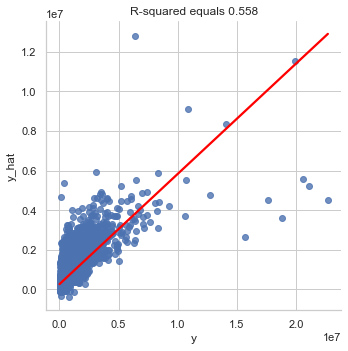

In [47]:
y_hat_h = model2.predict(X_h) #Insample predictions
sns.set_theme(style="whitegrid")
sns.lmplot(x="y", y="y_hat", data = pd.DataFrame({"y": y_h, "y_hat": y_hat_h}), ci=None,line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title("R-squared equals %.3f" %r2_score(y_h, y_hat_h))

We can see that in this model the $R^2$ increases to 0.558. The following code will prepare the matrix X with all the regressors from the training set with handled missing values. 

In [48]:
# X matrix for testing data
X_test_h = df_test_h.drop("lotid", axis = 1)

# Get missing columns in the testing test
missing_cols = set(X_h.columns) - set(X_test_h.columns)

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test_h[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
X_test_original_h = X_test_h[X_h.columns]

X_test_h = X_test_original_h.copy()

<ipython-input-48-4600068f3ca9>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_h[c] = 0


Now we can proceed to predict the `parcelvalue` for the testing set. 

In [49]:
y_hat_h = model2.predict(X_test_h) #Out of sample predictions

y_hat_h.mean()

459070.58854420506

### Third model 

Text(0.5, 1.0, 'R-squared equals 0.556')

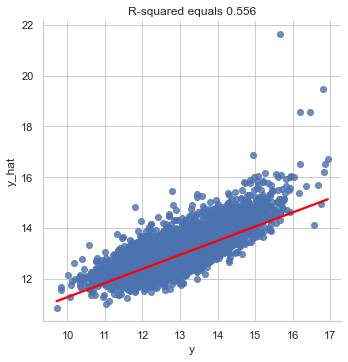

In [50]:
# Defining X matrix with all regressors and parcelvalue as y as the dependent variable
X_train = df_train_nh.drop(["lotid", "parcelvalue"], axis = 1)
y_train = df_train_nh.parcelvalue

X = X_train.copy()
y = y_train.copy()

# Drop not needed columns 
X = X.drop(["numfireplace", "lotarea", "roomnum"], axis = 1)
model3 = LinearRegression()
model3.fit(X, np.log(y))
y_hat_log = model3.predict(X) #Insample predictions

# As we have the predictions with log, we have to convert into level. 
y_hat = np.exp(y_hat_log)

# Check model performance 
sns.set_theme(style="whitegrid")
sns.lmplot(x="y", y="y_hat", data = pd.DataFrame({"y": np.log(y), "y_hat": y_hat_log}), ci=None,line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title("R-squared equals %.3f" %r2_score(np.log(y), y_hat_log))

In [51]:
X_test

,numbedroom,finishedarea,numfireplace,numfullbath,latitude,longitude,lotarea,roomnum,year,countycode2_3101,...,neighborhoodcode_764149.0,neighborhoodcode_764152.0,neighborhoodcode_764153.0,neighborhoodcode_764164.0,neighborhoodcode_764166.0,taxyear_2016,heatingtype_6.0,heatingtype_7.0,heatingtype_18.0,heatingtype_20.0
0,3,1618.0,0,3.0,34048500,-118438000,19423.0,0,1975.0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,1817.0,0,2.0,34023816,-118429617,7625.0,0,1948.0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1549.0,0,2.0,34125379,-117707983,11080.0,0,1978.0,1,...,0,0,0,0,0,1,0,0,0,0
3,3,1275.0,0,3.0,33878735,-118171388,58881.0,0,1991.0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,600.0,0,1.0,33766300,-118188000,47343.0,0,2004.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,1,672.0,0,1.0,34276978,-118342702,447679.0,0,1946.0,1,...,0,0,0,0,0,0,0,1,0,0
2742,4,1140.0,0,1.0,34424797,-118472198,6224.0,0,1962.0,1,...,0,0,0,0,0,0,0,0,0,0
2743,2,1368.0,0,3.0,34046900,-118440000,6614.0,0,1981.0,1,...,0,0,0,0,0,0,0,0,0,0
2744,2,1506.0,0,3.0,34144700,-118388000,280590.0,0,1973.0,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
X_test = X_test[X.columns]

The $R^2$ is practically the same as in the other models and the mean is similar to the one we got in the training set. 

In [53]:
y_hat_log_test = model3.predict(X_test)
y_hat_test = np.exp(y_hat_log_test)
y_hat_test.mean()

450884.5839726485

In [54]:
len(y_hat_test)

2746

### Fourth Model

Text(0.5, 1.0, 'R-squared equals 0.554')

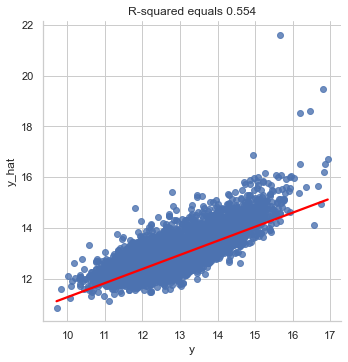

In [55]:
model4 = LinearRegression()
model4.fit(X_h, np.log(y_h))
y_hat_log_h = model4.predict(X_h) #Insample predictions
y_hat_h = np.exp(y_hat_log_h)
sns.set_theme(style="whitegrid")
sns.lmplot(x="y", y="y_hat", data = pd.DataFrame({"y": np.log(y_h), "y_hat": y_hat_log_h}), ci=None,line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title("R-squared equals %.3f" %r2_score(np.log(y_h), y_hat_log_h))

In [56]:
y_hat_log_test_h = model4.predict(X_test_h) # Outsample prediction
y_hat_test_h = np.exp(y_hat_log_test_h)
y_hat_test_h.mean()

452756.95035545266

### Fifth model

Text(0.5, 1.0, 'R-squared equals 0.553')

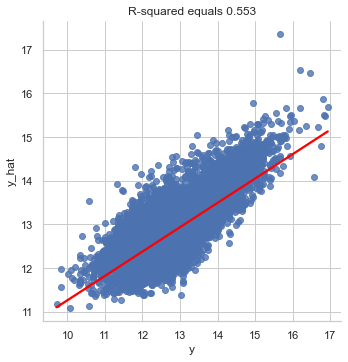

In [57]:
X["finishedarea"] = np.log(X["finishedarea"])  # Log to finished area 
X["lat_2"] = X["latitude"]**2
X["lon_2"] = X["longitude"]**2
model5 = LinearRegression()
model5.fit(X, np.log(y))
y_hat_log = model5.predict(X) #Insample predictions
y_hat = np.exp(y_hat_log)
sns.set_theme(style="whitegrid")
sns.lmplot(x="y", y="y_hat", data = pd.DataFrame({"y": np.log(y), "y_hat": y_hat_log}), ci=None,line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title("R-squared equals %.3f" %r2_score(np.log(y), y_hat_log))

In [58]:
X_test["finishedarea"] = np.log(X_test["finishedarea"])
X_test["lat_2"] = X_test["latitude"]**2
X_test["lon_2"] = X_test["longitude"]**2
y_hat_log_test = model5.predict(X_test)
y_hat_test = np.exp(y_hat_log_test)
y_hat_test.mean()

<ipython-input-58-fa6f12ebec77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["finishedarea"] = np.log(X_test["finishedarea"])
<ipython-input-58-fa6f12ebec77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["lat_2"] = X_test["latitude"]**2
<ipython-input-58-fa6f12ebec77>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

447098.322240942

### Sixth model

Text(0.5, 1.0, 'R-squared equals 0.570')

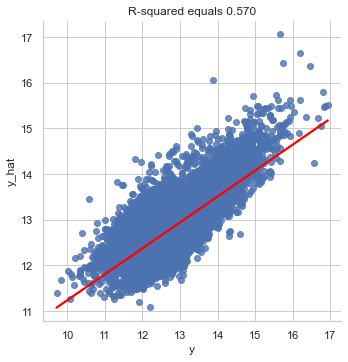

In [59]:
X_h = X_train_h.copy()
y_h = y_train_h.copy()

X_h = X_h.drop(["numfireplace", "lotarea", "roomnum"], axis = 1)

X_h["finishedarea"] = np.log(X_h["finishedarea"])  # Log to finished area 
X_h["lat_2"] = X_h["latitude"]**2
X_h["lon_2"] = X_h["longitude"]**2
model6 = LinearRegression()
model6.fit(X_h, np.log(y_h))
y_hat_log_h = model6.predict(X_h) #Insample predictions
y_hat_h = np.exp(y_hat_log_h)
sns.set_theme(style="whitegrid")
sns.lmplot(x="y", y="y_hat", data = pd.DataFrame({"y": np.log(y_h), "y_hat": y_hat_log_h}), ci=None,line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title("R-squared equals %.3f" %r2_score(np.log(y_h), y_hat_log_h))

In [60]:
X_test_h = X_test_original_h.copy()
X_test_h["finishedarea"] = np.log(X_test_h["finishedarea"])
X_test_h["lat_2"] = X_test_h["latitude"]**2
X_test_h["lon_2"] = X_test_h["longitude"]**2
y_hat_log_test_h = model6.predict(X_test_h)
y_hat_test_h = np.exp(y_hat_log_test_h)
y_hat_test_h.mean()

449716.1979195842

### Seventh model

In [61]:
# Training data
X = X_train.copy()
y = y_train.copy()
# Testing data
X_test = X_test_original.copy()
X = X.drop(["numfireplace", "lotarea", "roomnum"], axis = 1)
X_test = X_test.drop(["numfireplace", "lotarea", "roomnum"], axis = 1)
# Scaling variables 
X = scl(X)
X_test = scl(X_test)

# Training the model using AIC for model selection
model_aic = LassoLarsIC(criterion="aic", normalize=False)
model_aic.fit(X, np.log(y))

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:651: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=2.961e-02, with an active set of 30 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:651: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=2.220e-02, with an active set of 57 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:651: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 69 iterations, i.e. alpha=1.894e-02, with an active set of 69 regressors, and the smallest cholesky pivot ele

LassoLarsIC(normalize=False)

In [62]:
alpha=model_aic.alpha_
print('Hyperparameter:',alpha)

Hyperparameter: 0.01887369262723938


Hyperparameter which minimizes AIC is $\lambda = 0.018$. Let's get our insample predictions with this Lasso model

In [63]:
# Insamples predictions 
y_hat_log = model_aic.predict(X)

Text(0.5, 1.0, 'R-squared equals 0.494')

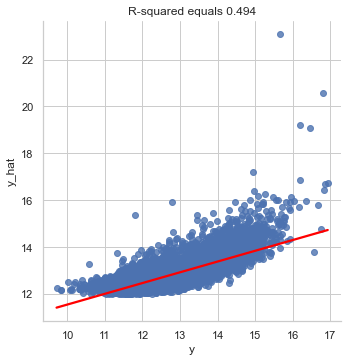

In [64]:
sns.set_theme(style="whitegrid")
sns.lmplot(x="y", y="y_hat", data = pd.DataFrame({"y": np.log(y), "y_hat": y_hat_log}), ci=None,line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title("R-squared equals %.3f" %r2_score(np.log(y), y_hat_log))

In [65]:
y_hat_test_log = model_aic.predict(X_test)
y_hat_test = np.exp(y_hat_test_log)

In [66]:
y_hat_test.mean()

465441.86393860186

In the following plot we can see that the hyperparameter $\lambda = 0.018$ is which minimizes AIC.

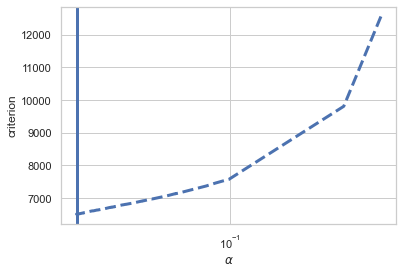

In [67]:
EPSILON = 1e-4
def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(
        model.alphas_ + EPSILON,
        criterion_,
        "--",
        color=color,
        linewidth=3,
        label="%s criterion" % name,
    )
    plt.axvline(
        model.alpha_ + EPSILON,
        color=color,
        linewidth=3,
        label="alpha: %s estimate" % name,
    )
    plt.xlabel(r"$\alpha$")
    plt.ylabel("criterion")


plt.figure()
plot_ic_criterion(model_aic, "AIC", "b")

### Eight model

This is the model with best performance in the kaggle competition. 

In [68]:
# Training data
X_h = X_train_h.copy()
y_h = y_train_h.copy()

X_h = X_h.drop(["numfireplace", "lotarea", "roomnum"], axis = 1)

# Testing data
X_test_h = X_test_original_h.copy()

In [69]:
X_h = scl(X_h)
X_test_h = scl(X_test_h)

In [70]:
model_aic = LassoLarsIC(criterion="aic", normalize=False, max_iter=30)
results_final_model = model_aic.fit(X_h, np.log(y_h))

In [71]:
alpha=model_aic.alpha_
print('Hyperparameter:',alpha)

Hyperparameter: 0.030077174843030362


Here the hyperparameter which minimizes the AIC is 0.03

In [72]:
y_hat_log_h = model_aic.predict(X_h)

Text(0.5, 1.0, 'R-squared equals 0.466')

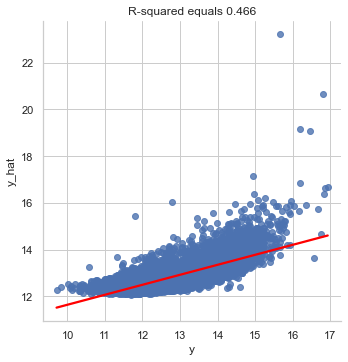

In [73]:
sns.set_theme(style="whitegrid")
sns.lmplot(x="y", y="y_hat", data = pd.DataFrame({"y": np.log(y_h), "y_hat": y_hat_log_h}), ci=None,line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title("R-squared equals %.3f" %r2_score(np.log(y_h), y_hat_log_h))

In [74]:
y_hat_test_log_h = model_aic.predict(X_test_h)

In [75]:
y_hat_test_h = np.exp(y_hat_test_log_h)

In [76]:
y_hat_test_h.mean()

463022.4649723253

## Step 6: Report variable impact


Since our best model is model 8, we will use this to report variable impact:

In [77]:
sorted(zip(X_train.columns, results_final_model.coef_), key=lambda x: x[1], reverse=True)

[('numfullbath', 0.3279303464955985),
 ('countycode2_3101', 0.164205382245037),
 ('regioncode_96957.0', 0.052355159330539296),
 ('neighborhoodcode_268509.0', 0.04846186447633302),
 ('neighborhoodcode_33183.0', 0.030387072309467866),
 ('regioncode_97001.0', 0.02641558199303475),
 ('neighborhoodcode_113688.0', 0.02277715563051573),
 ('citycode_26964.0', 0.01782987532979862),
 ('neighborhoodcode_32059.0', 0.014060935373281912),
 ('regioncode_96048.0', 0.013786264113877775),
 ('regioncode_96137.0', 0.01345531810225981),
 ('regioncode_96001.0', 0.012244991842349439),
 ('regioncode_96027.0', 0.012127702596906473),
 ('neighborhoodcode_30731.0', 0.008019199668672077),
 ('regioncode_96026.0', 0.007039501732365625),
 ('neighborhoodcode_274514.0', 0.00658015847685239),
 ('citycode_47019.0', 0.0028029118987249416),
 ('regioncode_96013.0', 0.0016384595995831879),
 ('citycode_51861.0', 0.0009047624022302056),
 ('numbedroom', 0.0),
 ('finishedarea', 0.0),
 ('numfireplace', 0.0),
 ('latitude', 0.0),
 

From the last output, we can see that `numfullbath` is the variable with has the largest impact on our model. We have seen that this variable is highly correlated with `parcelvalue` in the correlation matrix.  

## Step 7: Prepare code to run and check performance of you model using a new input data with same exact format




### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "lotid"'s and the other with your predicted "parcelvalue" for that observation

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [ ]:
# Step 8: Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"lotid": df_test_h["lotid"], "parcelvalue": y_hat_test_h})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)